In [5]:
import os
import time
import tqdm
import tempfile
import numpy as np
import scanpy as sc
import pandas as pd
import concurrent.futures
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import mmwrite
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from anndata import AnnData

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.conversion import localconverter

# Activate automatic pandas <-> R data.frame conversion
pandas2ri.activate()

In [6]:
adata_original = sc.read_h5ad('../xenium_data/Liver_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad')
adata = adata_original.copy()
adata

AnnData object with n_obs × n_vars = 22214 × 61806
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors', 'leide

In [7]:
adata = adata[(adata.obs['method'] == '10X') & (adata.obs['manually_annotated'] == 'True')].copy()
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
adata

AnnData object with n_obs × n_vars = 9855 × 61806
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std', 'ribo', 'hb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_co

In [8]:
adata.obs['free_annotation'].value_counts()

free_annotation
macrophage                      1877
hepatocyte                      1809
monocyte                        1584
endothelial cell                1045
t cell                           945
erythrocyte                      705
intrahepatic cholangiocyte       400
plasma cell                      336
natural killer cell              272
mature nk t cell                 227
hepatic stellate cell            177
b cell                           105
nk t cell                         99
neutrophil                        71
pre-natural killer cell           71
fibroblast                        69
dendritic cell                    38
hematopoietic precursor cell      19
mast cell                          4
classical monocyte                 2
Name: count, dtype: int64

In [9]:
adata = adata[~adata.obs['free_annotation'].isin(['mast cell', 'classical monocyte'])].copy()
adata

AnnData object with n_obs × n_vars = 9849 × 61806
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std', 'ribo', 'hb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_co

In [10]:
original_annotation = adata.obs['free_annotation'].copy()

In [11]:
# Define the function to run label transfer for one round
def run_label_transfer_single_perm(i):

    # Local import inside subprocess
    from scipy.io import mmwrite

    # Split data
    ref_idx, query_idx = train_test_split(adata.obs_names, test_size=0.2, random_state=i, stratify=adata.obs['free_annotation'])
    ref_obj = adata[ref_idx, :].copy()
    query_obj = adata[query_idx, :].copy()

    with tempfile.TemporaryDirectory() as tmpdir:
        ref_path = os.path.join(tmpdir, f"ref_{i}.mtx")
        query_path = os.path.join(tmpdir, f"query_{i}.mtx")

        mmwrite(ref_path, ref_obj.X.astype(np.float32).T)
        mmwrite(query_path, query_obj.X.astype(np.float32).T)

        # Inject into R globalenv
        ref_labels_r = StrVector(ref_obj.obs['free_annotation'].tolist())
        ro.globalenv['ref_labels'] = ref_labels_r
        ro.globalenv['ref_path'] = ref_path
        ro.globalenv['query_path'] = query_path

        # Run R code
        ro.r('''
        suppressMessages(suppressWarnings({
             library(Seurat)
             library(Matrix)

        query_data <- readMM(query_path)
        ref_data <- readMM(ref_path)

        query_seurat_obj <- CreateSeuratObject(counts = query_data)
        query_seurat_obj <- NormalizeData(query_seurat_obj, verbose = FALSE)
        query_seurat_obj <- FindVariableFeatures(query_seurat_obj, verbose = FALSE)
        query_seurat_obj <- ScaleData(query_seurat_obj, verbose = FALSE)
        query_seurat_obj <- RunPCA(query_seurat_obj, npcs=30, verbose=FALSE)
        query_seurat_obj <- RunUMAP(query_seurat_obj, dims=1:15, verbose = FALSE)
        query_seurat_obj <- FindNeighbors(query_seurat_obj, dims=1:15, verbose = FALSE)
        query_seurat_obj <- FindClusters(query_seurat_obj, resolution=0.5, verbose = FALSE)

        ref_seurat_obj <- CreateSeuratObject(counts = ref_data)
        ref_seurat_obj <- NormalizeData(ref_seurat_obj, verbose = FALSE)
        ref_seurat_obj <- FindVariableFeatures(ref_seurat_obj, verbose = FALSE)
        ref_seurat_obj <- ScaleData(ref_seurat_obj, verbose = FALSE)
        ref_seurat_obj <- RunPCA(ref_seurat_obj, npcs=30, verbose=FALSE)
        ref_seurat_obj <- RunUMAP(ref_seurat_obj, dims=1:15, verbose = FALSE)
        ref_seurat_obj <- FindNeighbors(ref_seurat_obj, dims=1:15, verbose = FALSE)
        ref_seurat_obj <- FindClusters(ref_seurat_obj, resolution=0.5, verbose = FALSE)

        anchors <- FindTransferAnchors(reference = ref_seurat_obj, query = query_seurat_obj, dims = 1:30, verbose = FALSE)
        label_transfer <- TransferData(anchorset = anchors, refdata = ref_labels, dims = 1:30, verbose = FALSE)
        }))
        ''')

        # Convert result to pandas Series
        with localconverter(default_converter + pandas2ri.converter):
            predicted_r = ro.r('label_transfer$predicted.id')
            predicted = ro.conversion.rpy2py(predicted_r)

        return pd.Series(predicted, index=query_idx, name=f"prediction_round_{i + 1}")

In [12]:
# Run in parallel using concurrent.futures
num_perms = 30 * 32
# results_df = pd.DataFrame(index=adata.obs_names)
results_df = pd.DataFrame(data=None, index=adata.obs_names, columns=[f"prediction_round_{i}" for i in range(num_perms)], dtype=object)
#Add the original label
results_df.insert(0, "original_annotation", adata.obs['free_annotation'])

with concurrent.futures.ProcessPoolExecutor(max_workers=min(num_perms, os.cpu_count())) as executor:
    futures = [executor.submit(run_label_transfer_single_perm, i) for i in range(num_perms)]
    for future in tqdm.tqdm(concurrent.futures.as_completed(futures), total=num_perms, desc=f"Running label transfer for {num_perms} permutations"):
        pred_series = future.result()
        results_df.loc[pred_series.index, pred_series.name] = pred_series.values
        # all_preds.append(pred_series)

results_df.to_csv('seurat_label_transfer_calibration_results.csv', sep=',', index=True)

Running label transfer for 960 permutations:   0%|          | 0/960 [00:00<?, ?it/s]


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    
    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    
    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    
    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    
    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    
    an issue that caused a se

Running label transfer for 960 permutations:  10%|█         | 100/960 [17:14<1:49:39,  7.65s/it]/tmp/ipykernel_111378/2729423891.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[pred_series.name] = pred_series
Running label transfer for 960 permutations:  11%|█         | 101/960 [17:22<1:49:09,  7.62s/it]/tmp/ipykernel_111378/2729423891.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[pred_series.name] = pred_series
Running label transfer for 960 permutations:  11%|█         | 102/960 [17:37<2:23:17

In [13]:
results_df = pd.read_csv('seurat_label_transfer_calibration_results.csv', sep=',', index_col=0)

In [15]:
# Get the list of prediction columns
prediction_cols = [col for col in results_df.columns if col.startswith("prediction_round_")]

# Flatten predictions into long format
long_df = results_df[['original_annotation'] + prediction_cols].melt(
    id_vars='original_annotation',
    value_vars=prediction_cols,
    var_name='round',
    value_name='predicted_label'
)

# Drop NaNs (cells that were not in the query for that round)
long_df = long_df.dropna()

# Compute per-cell-type accuracy
celltype_accuracy = (
    long_df
    .assign(correct=lambda df: df['original_annotation'] == df['predicted_label'])
    .groupby('original_annotation')['correct']
    .mean()
    .sort_values(ascending=False)
)

# Display accuracy per cell type
print(celltype_accuracy)

original_annotation
b cell                          1.000000
erythrocyte                     0.998463
hepatocyte                      0.997154
intrahepatic cholangiocyte      0.990182
endothelial cell                0.986090
plasma cell                     0.982354
monocyte                        0.971458
neutrophil                      0.969568
macrophage                      0.962195
t cell                          0.942019
pre-natural killer cell         0.891295
fibroblast                      0.865625
hepatic stellate cell           0.785268
natural killer cell             0.770448
dendritic cell                  0.594271
nk t cell                       0.562813
mature nk t cell                0.244606
hematopoietic precursor cell    0.077344
Name: correct, dtype: float64


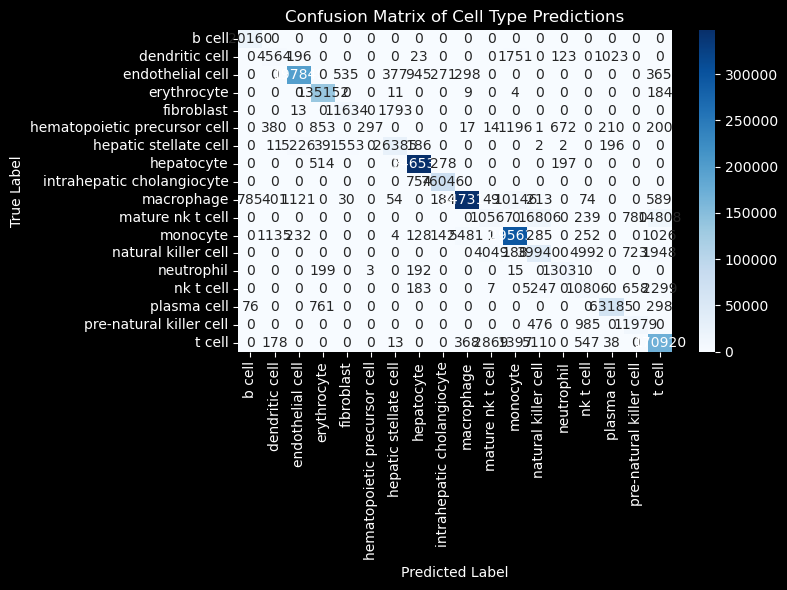

                              precision    recall  f1-score       support
b cell                         0.959041  1.000000  0.979092  2.016000e+04
dendritic cell                 0.684360  0.594271  0.636142  7.680000e+03
endothelial cell               0.966829  0.986090  0.976364  2.006400e+05
erythrocyte                    0.982795  0.998463  0.990567  1.353600e+05
fibroblast                     0.845986  0.865625  0.855693  1.344000e+04
hematopoietic precursor cell   0.990000  0.077344  0.143478  3.840000e+03
hepatic stellate cell          0.921360  0.785268  0.847888  3.360000e+04
hepatocyte                     0.993091  0.997154  0.995118  3.475200e+05
intrahepatic cholangiocyte     0.988625  0.990182  0.989403  7.680000e+04
macrophage                     0.982537  0.962195  0.972260  3.609600e+05
mature nk t cell               0.601902  0.244606  0.347850  4.320000e+04
monocyte                       0.952641  0.971458  0.961957  3.043200e+05
natural killer cell            0.58666

In [16]:
y_true = long_df['original_annotation']
y_pred = long_df['predicted_label']
labels = sorted(set(y_true) | set(y_pred))  # Sorted union of all labels
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Cell Type Predictions")
plt.tight_layout()
plt.show()

# Display classification report
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)